# Sistem za preporuku filmova zasnovan na kolaborativnom filtriranju

U ovom delu bavimo se izgradnjom sistema za preporuku koji je zasnovan na kolaborativnom filtriranju (eng. *collaborative filtering*). Ocene filmova se predviđaju na osnovu sličnosti među korisnicima (*user-based collaborative filtering*), odnosno među filmovima (*item-based collaborative filtering*). Preporučuju se oni filmovi za koje je predviđena ocena najviša. Učitajmo i pripremimo najpre neophodne podatke.

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from ast import literal_eval
from scipy import sparse as sps
from sklearn.metrics import mean_squared_error
import math
from scipy.sparse.linalg import svds

import warnings; warnings.simplefilter('ignore')

In [2]:
movies = pd.read_csv('the-movies-dataset/movies_metadata.csv',usecols=['id','title'])
movies.head()

,id,title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [3]:
ratings = pd.read_csv('the-movies-dataset/ratings_small.csv',usecols=['userId','movieId','rating'])
ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


## 1. KNN pristup 

Koristićemo algoritam K najbližih suseda. Podaci treba da budu u formi $m x n$ matrice, gde je $m$ broj filmova a $n$ broj korisnika. Primenjujemo funkciju **pivot** na dataFrame *ratings*. Zatim popunjavamo nedostajuće podatke nulama. Tako dobijamo novi dataFrame koji ćemo nazvati *ratings_pivot*.

In [4]:
ratings_pivot = ratings.pivot(index='userId',columns='movieId',values='rating').fillna(0)
ratings_pivot.head(5)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
ratings_pivot.shape

(671, 9066)

Matrica *ratings_pivot* je dosta retka, pa ćemo iskoristiti funkciju **csr_matrix** iz **scipy.sparse** paketa.

In [15]:
ratings_matrix = sps.csr_matrix(ratings_pivot)
print(ratings_matrix.todense())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]]


Delimo podatke na trening i test skup. Matrice treba da budu istih dimenzija, samo ocene drugačije raspodeljene.

In [7]:
def train_test_splitting(ratings_matrix, test_size): # test_size ocena ce biti u skupu za testiranje
    
    ratings = ratings_matrix.toarray()
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    rows = (ratings != 0).sum(1)
    
    for user in range(ratings.shape[0]):
        count_per_user=int(np.ceil(test_size*rows[user]))
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], # 0 jer je nonzero primenjeno na vektor
                                        size=count_per_user,  # indeksi na kojima nisu 0
                                        replace=False)
        # u trening skup se upisuju 0 na izabranim pozicijama, a u skup za testiranje se upisuju elementi 
        train[user, test_ratings] = 0
        test[user, test_ratings] = ratings[user, test_ratings] 
        
    # provera da li su poznate ocene ili u jednom ili u drugom skupu
    assert(np.all((train * test) == 0)) 
    return sps.csr_matrix(train),sps.csr_matrix(test)

Definišemo funkciju koja računa gustinu popunjenosti matrice. Trening i test skup treba da budu različite gustine, odnosno da imaju 4:1 odnos broja ne-nula elemenata.

In [13]:
def density(ratings): 
    density = float(len(ratings.nonzero()[0]))
    density /= (ratings.shape[0] * ratings.shape[1])
    density *= 100
    return round(density,3)

In [17]:
train, test = train_test_splitting(ratings_matrix, 0.2)
print('Non zero count - train: ',train.getnnz())
print('Density - train: ',density(train),'%')
print('Non zero count - test: ',test.getnnz())
print('Density - test: ',density(test),'%')

Non zero count - train:  79748
Density - train:  1.311 %
Non zero count - test:  20256
Density - test:  0.333 %


Implementiramo KNN algoritam.

In [31]:
def k_nearest_neighbors(i, similarity_matrix, k=10):
   
    neighbors = []
    similarities = list(zip(similarity_matrix[i][:],range(similarity_matrix.shape[0])))
    similarities.sort(key = lambda x: x[0], reverse=True)
    
    for i in range(1,k+1):
        neighbors.append(similarities[i][1])
    
    return neighbors

### User-based kolaborativno filtriranje
Računamo matricu sličnosti između korisnika. Računamo kosinusno rastojanje.

In [27]:
def similarity_between_users(ratings, epsilon=1e-9):
    return cosine_similarity(ratings) + epsilon 

In [30]:
users_similarity = similarity_between_users(train)
users_similarity.shape

(671, 671)

In [93]:
nearest_neighbors = k_nearest_neighbors(1,users_similarity)
nearest_neighbors

[534, 384, 516, 120, 648, 150, 125, 337, 589, 486]

Previđanje ocene korisnika $u$ za film $i$ na osnovu formule:
$ r'_{ui} = \mu_u + \frac{\sum_{v \in N^k_i(u)}sim(u,v)(r_{vi}-\mu_v)}{\sum_{v \in N^k_i(u)}sim(u,v)} $

In [162]:
def user_based_prediction(u, i, users_similarity, ratings, k):
        
        neighbors = k_nearest_neighbors(u,users_similarity,k)
        mu_u = ratings[u].mean()
        sum1 = 0.0
        sum2 = 0.0
    
        for v in neighbors:            
            mu_v = ratings[v].mean()
            r_vi = ratings[v,i]
            sum1 += users_similarity[u][v]*(r_vi - mu_v)
            sum2 += users_similarity[u][v]
            
    
        return mu_u + sum1/sum2

### Item-based kolaborativno filtriranje
Računamo matricu sličnosti između filmova. Računamo kosinusno rastojanje.

In [97]:
def similarity_between_movies(ratings, epsilon=1e-9):
    return cosine_similarity(ratings.T) + epsilon

In [98]:
movies_similarity = similarity_between_movies(train)
movies_similarity.shape

(9066, 9066)

In [99]:
nearest_neighbors = k_nearest_neighbors(5,movies_similarity)
nearest_neighbors

[24, 535, 45, 615, 644, 31, 87, 650, 406, 266]

Previđanje ocene korisnika $u$ za film $i$ na osnovu formule:
$ r'_{ui} = \mu_i + \frac{\sum_{j \in N^k_u(i)}sim(i,j)(r_{uj}-\mu_j)}{\sum_{j \in N^k_u(i)}sim(i,j)} $

In [100]:
def item_based_prediction(u, i, movies_similarity, ratings, k):
        
        neighbors = k_nearest_neighbors(i,movies_similarity,k)
        mu_i = ratings[:,i].mean()
        sum1 = 0.0
        sum2 = 0.0
    
        for j in neighbors:            
            mu_j = ratings[:,j].mean()
            r_uj = ratings[u,j]
            sum1 += movies_similarity[i][j]*(r_uj - mu_j)
            sum2 += movies_similarity[i][j]
            
    
        return mu_i + sum1/sum2

### Minimizacija RMSE na trening skupu

**!!! Zbog predugog vremena izvršavanja i tehničkih problema redukujemo skupove podataka !!! **

In [145]:
ratings_reduced = ratings_matrix[:150,:250] 
ratings_reduced.shape

(150, 250)

In [146]:
train_reduced, test_reduced = train_test_splitting(ratings_reduced, 0.2)
print(train_reduced.shape, test_reduced.shape)

(150, 250) (150, 250)


In [150]:
print('Density - train_reduced: ',density(train_reduced))
print('Non zero count - train: ',train_reduced.getnnz())
print('Density - test_reduced: ',density(test_reduced))
print('Non zero count - test: ',test_reduced.getnnz())

Density - train_reduced:  3.851
Non zero count - train:  1444
Density - test_reduced:  1.155
Non zero count - test:  433


In [151]:
users_similarity_reduced = similarity_between_users(train_reduced)
users_similarity_reduced.shape

(150, 150)

In [152]:
movies_similarity_reduced = similarity_between_movies(train_reduced)
movies_similarity_reduced.shape

(250, 250)

In [239]:
true_ratings = []
rows,cols = train_reduced.nonzero()

for row,col in zip(rows,cols):
    true_ratings.append(train_reduced[row,col])
    
len(true_ratings)

1444

In [154]:
true_ratings[:10]

[array(5.),
 array(5.),
 array(4.),
 array(4.),
 array(3.),
 array(3.),
 array(4.),
 array(3.),
 array(4.),
 array(3.)]

In [132]:
ks = [5,10,15,20,25,30,35,40]

Nalazimo najbolje *k* za user-based KNN, ono kojim se minimizuje RMSE na trening skupu.

In [178]:
errors1 = np.array([])
rows,cols = train_reduced.nonzero()

for k in ks:
    user_based_predictions = []
    for row,col in zip(rows,cols):
        u = row
        i = col
        prediction = user_based_prediction(u, i, users_similarity_reduced, train_reduced, k)
        user_based_predictions.append(prediction)

    error = np.sqrt(mean_squared_error(true_ratings,user_based_predictions))
    errors1 = np.append(errors1, error)

In [179]:
k_ub = ks[errors1.argmin()]
print('User-based train best k: ',k_ub)
print('User-based train RMSE :', errors1.min())

User-based train best k:  5
User-based train RMSE : 2.3874080351478257


Nalazimo najbolje *k* za item-based KNN, ono kojim se minimizuje RMSE na trening skupu.

In [181]:
errors2 = np.array([])
rows,cols = train_reduced.nonzero()

for k in ks:
    item_based_predictions = []
    for row,col in zip(rows,cols):
        u = row
        i = col
        prediction = item_based_prediction(u, i, movies_similarity_reduced, train_reduced, k)
        item_based_predictions.append(prediction)
        
    error = np.sqrt(mean_squared_error(true_ratings,item_based_predictions))
    errors2 = np.append(errors2, error)

In [182]:
k_ib = ks[errors2.argmin()]
print('Item-based train best k :', k_ib)
print('Item-based train RMSE :', errors2.min())

Item-based train best k : 5
Item-based train RMSE : 2.314105042751845


Vizualizacija zavisnosti RMSE od broja suseda *k*.

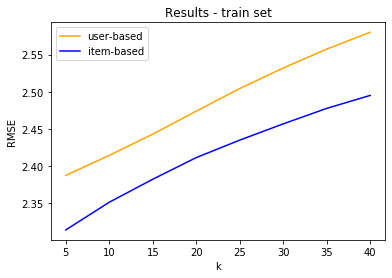

In [195]:
plt.plot(ks, errors1, color = 'orange', label = 'user-based')
plt.plot(ks, errors2, color = 'blue', label = 'item-based')
plt.title('Results - train set')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

### Validacija na test skupu

In [222]:
test_ratings = []
rows,cols = test_reduced.nonzero()

for row,col in zip(rows,cols):
    test_ratings.append(test_reduced[row,col])

len(test_ratings)

433

In [189]:
errors_test_1 = np.array([])
rows,cols = test_reduced.nonzero()

for k in ks:
    user_based_predictions = []
    for row,col in zip(rows,cols):
        u = row
        i = col
        prediction = user_based_prediction(u, i, users_similarity_reduced, test_reduced, k)
        user_based_predictions.append(prediction)

    error = np.sqrt(mean_squared_error(test_ratings,user_based_predictions))
    errors_test_1 = np.append(errors_test_1, error)

In [190]:
k_ub_test = ks[errors_test_1.argmin()]
print('User-based test best k : ',k_ub_test)
print('User-based test RMSE :', errors_test_1.min())

User-based test best k :  10
User-based test RMSE : 3.401826067892353


In [191]:
errors_test_2 = np.array([])
rows,cols = test_reduced.nonzero()

for k in ks:
    item_based_predictions = []
    for row,col in zip(rows,cols):
        u = row
        i = col
        prediction = item_based_prediction(u, i, movies_similarity_reduced, test_reduced, k)
        item_based_predictions.append(prediction)

    error = np.sqrt(mean_squared_error(test_ratings,item_based_predictions))
    errors_test_2 = np.append(errors_test_2, error)

In [192]:
k_ib_test = ks[errors_test_2.argmin()]
print('Item-based test best k : ',k_ib_test)
print('Item-based test RMSE :', errors_test_2.min())

Item-based test best k :  15
Item-based test RMSE : 3.473562310321318


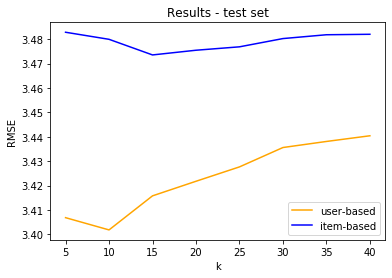

In [196]:
plt.plot(ks, errors_test_1, color = 'orange', label = 'user-based')
plt.plot(ks, errors_test_2, color = 'blue', label = 'item-based')
plt.title('Results - test set')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

## 2. Dekompozicija matrica
Još jedan pristup zasnovan na kolaborativnom filtriranju jeste korišćenjem singularne dekompozicije matrica (SVD). Kako je matrica ocena $R$ retka (jedan korisnik je ocenio samo mali deo filmova), ona se može dekomponovati kao $R = M\Sigma U^T$, gde je $U$ matrica korisnika, $M$ matrica filmova, a $\Sigma$ je dijagonalna matrica. Jednostavnosti radi, možemo posmatrati jednakost bez dijagonalne matrice, odnosno samo $R = MU^T$.
Označimo sa $r_{ui}$ ocenu korisnika $u$ za film $i$, sa $p_u$ red matrice $M$ koji se odnosi na korisnika $u$ i sa $q_i$ kolonu matrice $U^T$ koja se odnosi na film $i$. Dobijamo jednakost na osnovu koje se vrši predviđanje ocena: $$ r_{ui}= p_uq_i$$ 

In [199]:
M, sigma, Ut = svds(train, k = 4)

In [200]:
sigma = np.diag(sigma)
sigma

array([[137.38546275,   0.        ,   0.        ,   0.        ],
       [  0.        , 168.0202303 ,   0.        ,   0.        ],
       [  0.        ,   0.        , 199.70283511,   0.        ],
       [  0.        ,   0.        ,   0.        , 414.3766936 ]])

In [246]:
predictions_svd_matrix = np.dot(np.dot(M,sigma),Ut)
train_predictions_svd = list(predictions_svd_matrix[train.nonzero()].flatten())
len(train_predictions_svd)

79748

In [241]:
train_ratings_svd = []
rows,cols = train.nonzero()

for row,col in zip(rows,cols):
    train_ratings_svd.append(train[row,col])

len(train_ratings_svd)

79748

In [245]:
rmse_train_svd = np.sqrt(mean_squared_error(train_ratings_svd,train_predictions_svd))
print('Singular Value Decomposition train RMSE: ',rmse_train_svd)

Singular Value Decomposition train RMSE:  2.9547902603074463


In [247]:
test_predictions_svd = list(predictions_svd_matrix[test.nonzero()].flatten())
len(test_predictions_svd)

20256

In [248]:
test_ratings_svd = []
rows,cols = test.nonzero()

for row,col in zip(rows,cols):
    test_ratings_svd.append(test[row,col])

len(test_ratings_svd)

20256

In [249]:
rmse_test_svd = np.sqrt(mean_squared_error(test_ratings_svd,test_predictions_svd))
print('Singular Value Decomposition test RMSE: ',rmse_test_svd)

Singular Value Decomposition test RMSE:  3.050234191945162


### NOTE
* Eventualna implementacija rikomendera... 

## 3. Metod latentnih faktora

Singularna dekompozicije (SVD) matrice ocena može biti skupa jer je matrica retka. Takođe, SVD ne radi kada podaci nedostaju. To umanjuje performanse. Sledeći pristup predviđanja ocena će se sastojati u pronalaženju ovih fakora tako da se minimizuje regularizovana kvadratna greška na trening skupu: $$min_{q^*,p^*,b^*} \sum_{(u,i) \in s} (r_{ui} - q^T_ip_u)^2 + \lambda(||q_i||^2 + ||p_u||^2)$$

Ovo radimo koristeći stohastički gradijentni spust. Najpre inicijalizujemo tražene matrice nasumičnim vrednostima iz unifomne raspodele. Zatim za svaki par (korisnik-film, ocena) iz trening skupa ažuriramo parametre prema grešci između stvarne i predviđene ocene. Na primer, faktor korisnika $p_u$ se ažurira na sledeći način:
$$ p_u = p_u + \alpha*((r_{ui} - r'_{ui})q_i - \lambda p_u)$$

In [258]:
# RMSE za SGD
def RMSE(data, Q, P):
    I = data != 0  # indikatorska funkcija o ocenjenim filmovima
    ME = I * (data - np.dot(P, Q.T))  # greska izmedju stvarnih i predvidjenih vrednosti
    MSE = ME**2  
    return np.sqrt(np.sum(MSE)/np.sum(I)) 

In [255]:
f = 5 # broj parova latentnih faktora
number_of_epochs = 10 # broj iteracija petlje
l = 0.5 # regularizacioni parametar
alpha = 0.01 # learning rate

In [266]:
def stohastic_gradient_descent(train, test, f, number_of_epochs, l, alpha):
    
    users,items = train.nonzero()    
    P = np.random.rand(train.shape[0], f) # latentni faktori za korisnike
    Q = np.random.rand(train.shape[1], f) # latentni faktori za filmove
    
    train_errors = []
    test_errors = []
    
    for epoch in range(number_of_epochs):
        for u, i in zip(users, items):
            diff = train[u, i] - np.dot(P[u,:], Q[i,:].T) # razlika izmedju prave i predvidjene vrednosti
            # azuriranje faktora za korisnike
            P[u, :] += alpha * (diff * Q[i,:] - l * P[u,:])
            #azuriranje faktora za filmove
            Q[i, :] += alpha * (diff * P[u,:] - l * Q[i, :])
        train_errors.append(RMSE(train.toarray(),Q,P))
        test_errors.append(RMSE(test.toarray(),Q,P))
    
    return train_errors, test_errors


In [267]:
train_errors, test_errors = stohastic_gradient_descent(train_reduced, test_reduced, f, number_of_epochs, l, alpha)

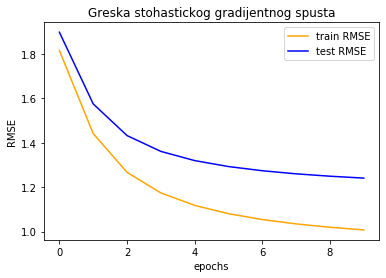

In [271]:
plt.plot(train_errors, color="orange", label='train RMSE')
plt.plot(test_errors, color="blue", label='test RMSE')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.title('Greska stohastickog gradijentnog spusta')
plt.legend(loc = 'best')
plt.show()

### NOTE
* Eventualna implementacija rikomendera... 